### 4. Content match: mapping Train database to O*Net database
The real world job titles are very diversified. 
"Web Front-End Developer","Javascript Programmers","Frontend Engineer"...are similar jobs that we wanted to map them
to O*NET "Standard" occupation "Web Developer". Once the mapping is done, we get career cluster label for free.
If we make mistakes in predicing at occupation level,for example, we labeled "Jave developer" as "Web Developer" instead of "Software Programmer", we still can get the career cluster label right because both"software Programmer" and "Web Developer" belong to "IT" career cluster. So the point is, some mistakes that we made at occupation level gets corrected at "Career Cluster" level.

The mapping is done by looking at the title and description all together. When building our corpus, we only use the content from O*NET. The words outside of O*NET corpus are simplied ignored. We choose term-frequency inverse document frequency presentation. Think about in the phrase "Financial analysis manager",the word "financial" should have more weight than "analysis" or "manager" in predicting career cluster. We use tf-idf presentation to locate the nearest occupation in O*NET to the job listing that I am looking at. 

As a side note, I make my own stop words list. When I remove the non letters characters in the data cleaning steps, it left words fragments. There are some HR specific words like "applicants","qualified". Those words are added to sklearn stopwords list.

### 5. Train the model
We initialize scores for each skills with the scores in O*NET. You may wondering that different jobs like "Web Front-End Developer","Javascript Programmers" will have different requirement. That is correct. Another way to think this problem is our input data is noisy. Instead of getting programming scores "3.5,4.0,3.7...4.5" for all kinds of web developers, we can 4.0 for all of them. By and large, we are still right, because web developers do have higher average score in programming than "Sales Manager".

To predict skill scores for jobs, we build linear regression model to learn the weight for each word to predict score.
At this point, we don't need O*NET description anymore. We use title and description from real world job listings.
There are 68 items in skills and knowledge.We repeated this process for 68 times. It took 1.5 hours to train the models in my macbook pro. 

### 6. Predict training data score
In the mapping stage, all the jobs mapped to one O*NET Occupation are given the same score. Now the models have learned the weight for each word, so we can use the models to predict each job description to get a more precise score. 

To have some sanity check, I plotted the distribution of "Economics and Accounting" score for jobs in the "Finance" cluster against jobs in the "Business Management & Administration" cluster. Indeed, jobs in "Finance" cluster require
more knowledge in "Economics and Accounting", just as we expected.

Also, words_for_skill function plot the most siginificant words in predicting one particular skill.

### 7. Normalize training data score
The scores predicted from linear regression is not bound to 0 to 5. Also, scores for soft skills like "crital thinking",'Actively listening" are overall much higher than scores for techinical skills like "programming" or "installation". Remember these scores in O*NET originally came from Survey. Many people think their jobs need critical thinking, but the scores do not help us distinguish one job from another. For the reasons above, I rescale the predicted score to its percentile. 

## 0. Load in Library

In [183]:
import re
import pandas as pd
import sys
import os
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from sklearn.externals import joblib
import json
import io

## 4. Content match 

* read in two cleaned tables

In [178]:
mapping_mode = False
training_mode = False
predicting_mode = True # transform training and test data, sanity check
query_mode = True

In [158]:
if mapping_mode:
    onet_all_df = pd.read_csv('onet_all_info.csv')
    listing_all_df = pd.read_csv('listing_database_clean.csv')

In [159]:
def readJson(filename):
    with open(filename,'r') as f:
        s = json.load(f)
    return s

predictors = readJson('predictors.json')
all_predictors=predictors['Knowledge']+predictors['Skills']
onet_columns = [u'O*NET-SOC Code', u'id', u'Career Cluster',u'Career Pathway', u'Occupation']+all_predictors

In [160]:
if mapping_mode:  
    my_additional_stop_words = set(readJson('stopwords.json'))
    my_stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

* Vectorize O*NET 'Summary' (combined featurs of 'Occupation','Related Titles','Tasks','description')

In [161]:
if mapping_mode:
    tfidf_vector = TfidfVectorizer(strip_accents='unicode',ngram_range=(1,2),lowercase =True, stop_words=my_stop_words)
    tfidf_vector.fit(onet_all_df['summary'])
    onet_matrix = tfidf_vector.transform(onet_all_df['summary'])
    onet_corpus = tfidf_vector.vocabulary_
    listing_matrix = tfidf_vector.transform(listing_all_df['text'])

* Calculate distances, and map listing data to O*NET data

In [162]:
if mapping_mode:
    distances = pairwise_distances(listing_matrix, onet_matrix, metric='cosine')
    listing_all_df['id'] = np.argmin(distances,axis=1)
    listing_all_df.drop_duplicates(subset=['company','id'],inplace=True)
    listing_label_df = listing_all_df.merge(onet_all_df[onet_columns],how='left',on='id').copy()
    listing_label_df.to_csv('score_model_2/listing_mapped_to_onet_final.csv',index = False)

In [163]:
if not mapping_mode:
    listing_label_df=pd.read_csv('score_model_2/listing_mapped_to_onet_final.csv')

## 5. Train the Model

* Train and Test split

In [164]:
if training_mode or predicting_mode:
    train_df, test_df = train_test_split(listing_label_df,test_size=0.33, random_state=14)

* Vectorize train['text'] (listing title and description combined)

In [165]:
if training_mode:
    tfidf_vect = TfidfVectorizer(strip_accents='unicode',max_df = 0.2,
                                                  min_df = 5,
                                                  token_pattern = '\\b\\w{3,20}\\b',
                                                  ngram_range = (1,2), 
                                                  stop_words = my_stop_words)
    tfidf_vect.fit(train_df['text'])                                    
    train_matrix = tfidf_vect.transform(train_df['text'])
    train_corpus = tfidf_vect.vocabulary_
    joblib.dump(tfidf_vect,"score_model_2/tfidf.vect")

### Setup pipeline for grid search

In [166]:
if training_mode:
    def get_best_model(features, labels):
        pipeline = Pipeline([
                             ('SGD', linear_model.SGDRegressor(loss ='squared_epsilon_insensitive',n_iter=150))
                            ])

        param_grid = {'SGD__epsilon': [0.2],
                      'SGD__l1_ratio':[0.05,0.15],
                      'SGD__alpha':[0.001,0.0001,0.00001]}
        search_grid = GridSearchCV(estimator=pipeline, 
                                   param_grid=param_grid, 
                                   cv=5,
                                   verbose=1,
                                   refit=True)
        search_grid.fit(features,labels)
        best_estimator = search_grid.best_estimator_
        return best_estimator

    def get_words_weight(predictor,model):
        feature_map = tfidf_vect.get_feature_names()
        wt = best_estimator[predictor].named_steps['SGD'].coef_
        feature_scores = sorted(zip(feature_map, wt),key=lambda x:x[1],reverse=True)[0:300]
        return feature_scores

### Begin to train the model, takes about 1.5 hours

In [167]:
if training_mode:
    best_estimator={}
    model_words_weight={}
    for predictor in all_predictors:
        best_estimator[predictor] = get_best_model(train_matrix,train_df[predictor])
        model_words_weight[predictor] = get_words_weight(predictor,best_estimator[predictor])
        joblib.dump(best_estimator[predictor], "score_model_2/"+predictor+".sgd")  
    important_words = pd.DataFrame(model_words_weight)
    important_words.to_csv('score_model_2/model_important_words.csv')

### Look at top words for each model

In [168]:
important_words = pd.read_csv('score_model_2/model_important_words.csv')

### Skill name and index lookup table

In [206]:
col_names = important_words.drop('Unnamed: 0',axis=1).columns
pd.DataFrame(col_names, columns=['Skill Name'])

,Skill Name
0,Active Learning
1,Active Listening
2,Administration and Management
3,Biology
4,Building and Construction
5,Chemistry
6,Clerical
7,Communications and Media
8,Complex Problem Solving
9,Computers and Electronics


### Input the skill_index for the skill_name 

In [208]:
def words_for_skill(skill_id):
    pd.set_option('display.max_rows', None)
    skill_name = col_names[skill_id]
    print skill_name
    one_skill = pd.DataFrame(important_words[skill_name])
    one_skill['s']=one_skill[skill_name].apply(lambda s: s.lstrip("(u'").rstrip(")"))
    one_skill['word'] = one_skill['s'].apply(lambda s: s.split(",")[0].rstrip("'"))
    one_skill['score'] = one_skill['s'].apply(lambda s: float(s.split(",")[1]))
    sns.barplot(y='word',x='score',data=one_skill.iloc[0:20])

Economics and Accounting


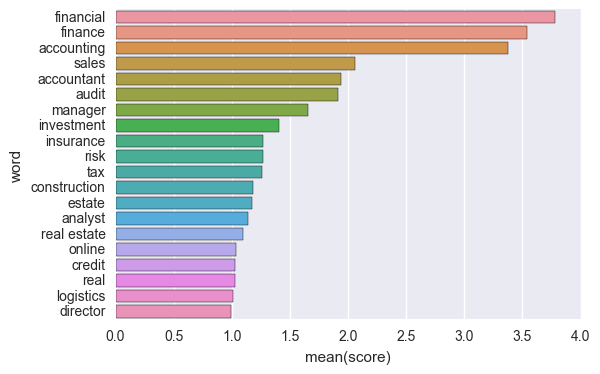

In [210]:
words_for_skill(14)

## 6. Train prediction

In [172]:
if not training_mode and predicting_mode:
    tfidf_vect = joblib.load("score_model_2/tfidf.vect")
    best_estimator={}
    for predictor in all_predictors:
        best_estimator[predictor] = joblib.load("score_model_2/"+predictor+".sgd")
        

In [173]:
if query_mode or predicting_model:
    class my_prediction:
        def __init__(self,query_df,tfidf_vect,models):
            self.query_df = query_df
            self.tfidf_vect = tfidf_vect
            self.models = models
            self.clean_text()
            self.vectorizer()

        def clean_text(self):
            self.query_df['clean_text'] = self.query_df['text'].apply(lambda x: re.sub(r'\s',' ', x).lower())

        def vectorizer(self):
            self.query_matrix = self.tfidf_vect.transform(self.query_df['clean_text'])
            return self

        def predict_score(self):
            self.score_df = self.query_df
            for i, predictor in enumerate(self.models.keys()):     
                prediction = self.models[predictor].predict(self.query_matrix)
                self.score_df[predictor]=prediction
            return self.score_df

###  distribution of "Economics and Accounting" scores on training data before modeling

In [200]:
def plot_distribution(df,predictor):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    df.groupby('Career Cluster')[predictor].plot.hist(ax=ax,bins=50,alpha=0.5,legend = True, fontsize=15)
    ax.set_xlabel("Score",fontsize=18)
    ax.set_ylabel("Frequency",fontsize=18)
    ax.set_title(predictor,fontsize=22)
    ax.legend(fontsize=15,loc=1)

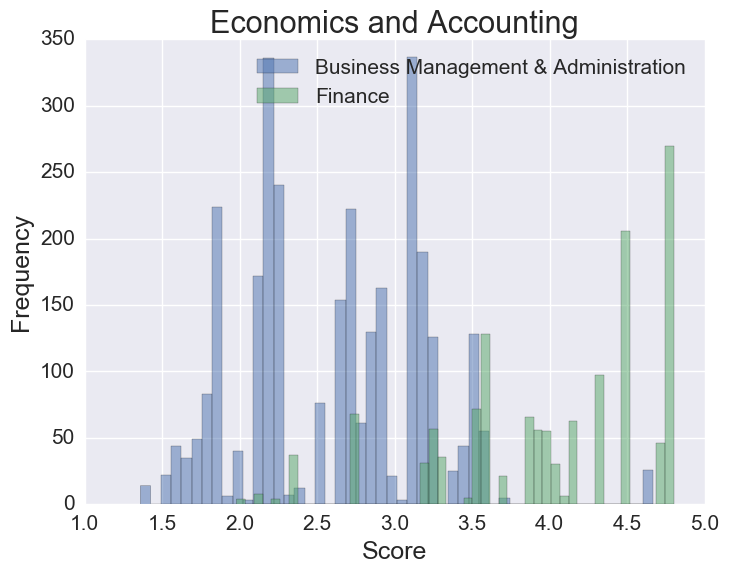

In [202]:
if predicting_mode:
    train_before= train_df[train_df['Career Cluster'].isin(['Business Management & Administration','Finance'])].copy()                                                                           
    plot_distribution(train_before, 'Economics and Accounting')

## Distribution of "Economics and Accounting" score of train data after prediction

In [179]:
if predicting_mode:
    train_df_for_predict = train_df[['company','text','listing_title','original_id','id','O*NET-SOC Code','Occupation','Career Pathway','Career Cluster']].copy()
    train_prediction = my_prediction(train_df_for_predict,tfidf_vect,best_estimator)
    train_predicted_score_df= train_prediction.predict_score()
    train_predicted_score_df.to_csv('score_model_2/listing_train_predict_score.csv',index=None)
else:
    train_predicted_score_df = pd.read_csv('score_model_2/listing_train_predict_score.csv')

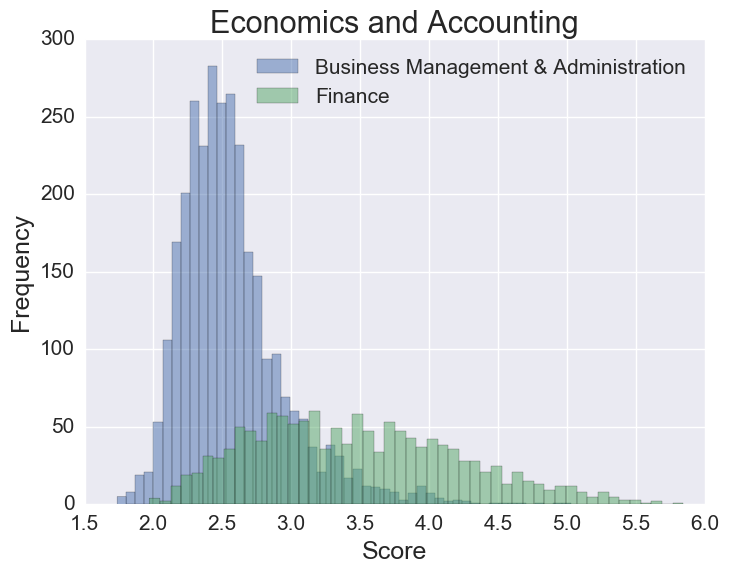

In [203]:
predictor='Economics and Accounting'
subset_train= train_predicted_score_df[train_predicted_score_df['Career Cluster'].isin(['Business Management & Administration',
                                                                     'Finance'])].copy()
                                                                     
plot_distribution(subset_train,predictor)

In [218]:
EA = train_predicted_score_df[['Career Cluster','Economics and Accounting']]

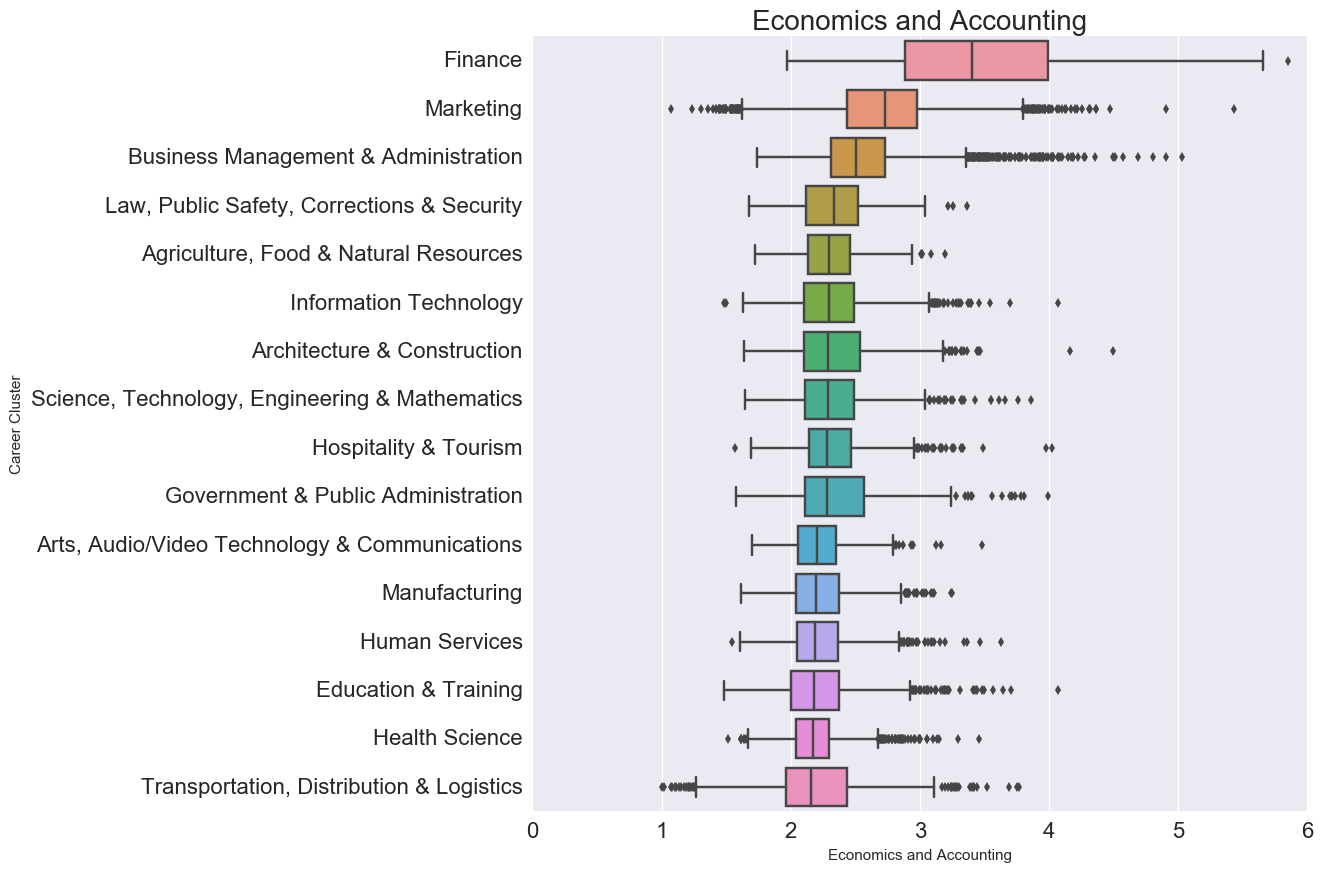

In [241]:
def plot_feature_score(score_df):
    Order = score_df.groupby('Career Cluster')['Economics and Accounting'].median().sort_values(ascending = False).index
    sns_plot = sns.boxplot(x='Economics and Accounting',y='Career Cluster',order=Order, data = score_df) 
    sns_plot.axes.set_xlim([0,6.0])
plt.figure(figsize=(10,10))
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.xlabel()
#plt.ylabel()
plt.title('Economics and Accounting',fontsize = 20)
plot_feature_score(EA)

## Distribution of "Economics and Accounting" score  for test data

In [181]:
if predicting_mode:
    test_df_for_predict = test_df[['company','text','listing_title','original_id','id','O*NET-SOC Code','Occupation','Career Pathway','Career Cluster']].copy()
    test_prediction = my_prediction(test_df_for_predict,tfidf_vect,best_estimator)
    test_predicted_score_df= test_prediction.predict_score()
    test_predicted_score_df.to_csv('score_model_2/listing_test_predict_score.csv',index=None)
else:
    test_predicted_score_df = pd.read_csv('score_model_2/listing_test_predict_score.csv')


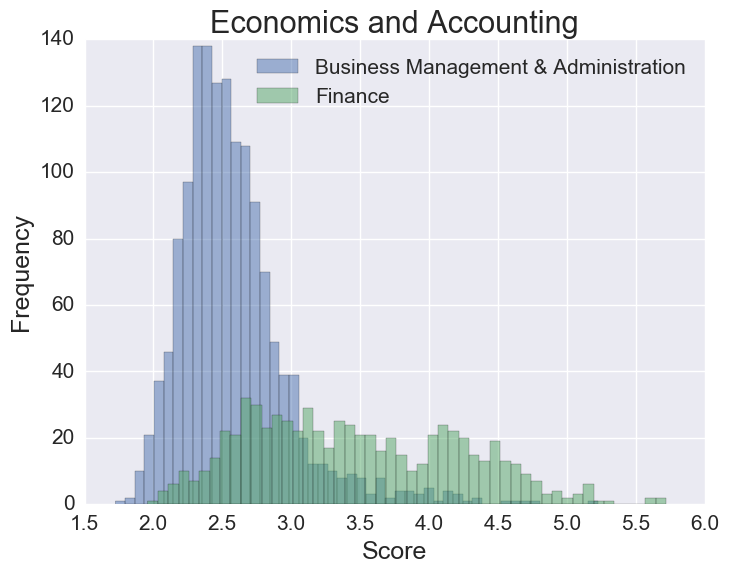

In [204]:
subset_test= test_predicted_score_df[test_predicted_score_df['Career Cluster'].isin(['Business Management & Administration',
                                                                         'Finance'])].copy()
                                                                         

plot_distribution(subset_test,predictor)

In [153]:
if predicting_mode:
    listing_train_for_query_df = train_predicted_score_df.copy()
    listing_train_for_query_df.drop(['company','text','listing_title','original_id','clean_text'],axis=1,inplace=True)
    listing_train_for_query_df.to_csv('score_model_2/listing_train_for_query.csv',index=None)

## 7. Normalize prodiction Score to percentile

In [155]:
if predicting_mode:   
    from scipy.stats import percentileofscore
    
    def cal_percentile(s,col):
        score = percentileofscore(listing_train_for_query_df[col].values, s, kind='mean')
        return score

    def normalize_score(df,all_predictors):
        normalized_df = df.copy()
        for col in all_predictors:
            normalized_df[col]=df[col].apply(lambda x: cal_percentile(x,col))
        return normalized_df
    
    listing_train_normalized_score_df = normalize_score(listing_train_for_query_df,all_predictors)
    listing_train_normalized_score_df.to_csv('score_model_2/listing_train_normalized_score.csv',index=None)

In [156]:
listing_train_normalized_score_df.head(2)

,id,O*NET-SOC Code,Occupation,Career Pathway,Career Cluster,Writing,Clerical,Instructing,Psychology,Active Learning,...,Therapy and Counseling,Food Production,Medicine and Dentistry,Design,Production and Processing,Foreign Language,Geography,Telecommunications,Judgment and Decision Making,Customer and Personal Service
18912,620,43-4031.03,License Clerks,Public Management and Administration,Government & Public Administration,19.887057,39.597506,35.611809,70.645822,18.958224,...,79.445753,15.866475,80.169632,13.930316,12.652625,29.515524,8.278824,11.719431,17.109280,35.694662
13537,546,37-3011.00,Landscaping and Groundskeeping Workers,Maintenance/Operations,Architecture & Construction,1.445578,10.245508,4.027124,4.607099,1.314757,...,18.583203,63.790773,27.535758,73.100907,67.955259,14.614949,45.174865,2.269754,2.034275,8.789028
